In [1]:
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from keras.callbacks import EarlyStopping
from keras.losses import MeanAbsolutePercentageError
import tensorflow as tf
import keras


In [3]:
df = pd.read_csv('raw_data/BTC-USD.csv', parse_dates=True, index_col='Date')


In [4]:
df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...
2021-11-18,60360.136719,60948.500000,56550.792969,56942.136719,56942.136719,4.138834e+10
2021-11-19,56896.128906,58351.113281,55705.179688,58119.578125,58119.578125,3.870241e+10
2021-11-20,58115.082031,59859.878906,57469.726563,59697.195313,59697.195313,3.062426e+10


In [5]:
df = df.fillna(df.mean())
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...
2021-11-18,60360.136719,60948.500000,56550.792969,56942.136719,56942.136719,4.138834e+10
2021-11-19,56896.128906,58351.113281,55705.179688,58119.578125,58119.578125,3.870241e+10
2021-11-20,58115.082031,59859.878906,57469.726563,59697.195313,59697.195313,3.062426e+10


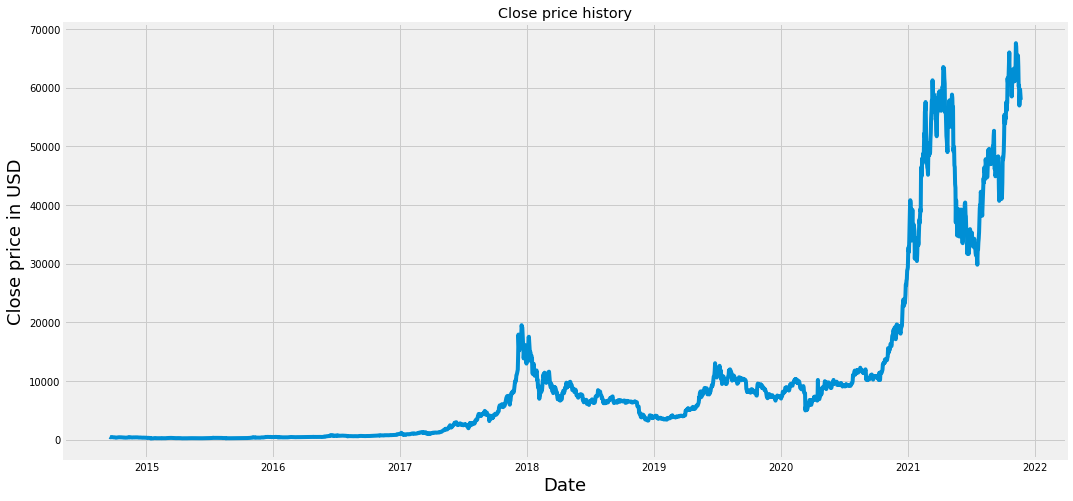

In [6]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(df.Close)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price in USD', fontsize=18)
plt.show()

In [7]:
def subsample_sequence(df, length):
    # $CHALLENGIFY_BEGIN
    last_possible = df.shape[0] - length - 5
    
    random_start = np.random.randint(0, last_possible)
    X = df[random_start: random_start+length].values
    y = df.iloc[random_start+length+5]['Close']
    # $CHALLENGIFY_END
    return X, y

subsample_sequence(df, 10)

(array([[6.65281006e+02, 6.91731018e+02, 6.46559021e+02, 6.65122986e+02,
         6.65122986e+02, 1.26656000e+08],
        [6.65931030e+02, 6.65979980e+02, 6.16934021e+02, 6.29367004e+02,
         6.29367004e+02, 1.09225000e+08],
        [6.29348999e+02, 6.55275024e+02, 6.20523987e+02, 6.55275024e+02,
         6.55275024e+02, 1.22134000e+08],
        [6.58101990e+02, 6.59247986e+02, 6.37773010e+02, 6.47000977e+02,
         6.47000977e+02, 1.38384992e+08],
        [6.44122009e+02, 6.44682007e+02, 6.28283997e+02, 6.39890015e+02,
         6.39890015e+02, 1.42456000e+08],
        [6.40591003e+02, 6.75403015e+02, 6.36607971e+02, 6.73336975e+02,
         6.73336975e+02, 1.38980000e+08],
        [6.72515015e+02, 6.86153992e+02, 6.69593994e+02, 6.76296021e+02,
         6.76296021e+02, 1.34431008e+08],
        [6.76734009e+02, 7.03702026e+02, 6.76398987e+02, 7.03702026e+02,
         7.03702026e+02, 1.12354000e+08],
        [7.04968018e+02, 7.04968018e+02, 6.49008972e+02, 6.58664001e+02,
       

In [8]:
def get_X_y(df, length_of_observations):
    X, y = [], []
    # $CHALLENGIFY_BEGIN
    for length in length_of_observations:
        xi, yi = subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
    # $CHALLENGIFY_END
    return X, y

length_of_observations = np.random.randint(200, 300, 50)
X, y = get_X_y(df, length_of_observations)


In [9]:
horizon = 5
gap = horizon - 1

len_ = int(0.8*df.shape[0])

df_train = df[:len_]
df_test = df[len_+gap:]

In [10]:
length_of_observations = np.random.randint(200, 300, 50)
X_train, y_train = get_X_y(df, length_of_observations)

length_of_observations = np.random.randint(200, 300, 50)
X_test, y_test = get_X_y(df, length_of_observations)

In [11]:
X_train[0][:]

array([[2.69306000e+02, 2.70769989e+02, 2.63838989e+02, 2.66272003e+02,
        2.66272003e+02, 2.56373000e+07],
       [2.66496002e+02, 2.76510010e+02, 2.66135010e+02, 2.74023010e+02,
        2.74023010e+02, 3.78086000e+07],
       [2.73648987e+02, 2.78683990e+02, 2.73542999e+02, 2.76496002e+02,
        2.76496002e+02, 2.94425000e+07],
       ...,
       [6.64796997e+02, 6.68700012e+02, 6.54468018e+02, 6.54468018e+02,
        6.54468018e+02, 1.31449000e+08],
       [6.52922974e+02, 6.62901978e+02, 6.52922974e+02, 6.58078003e+02,
        6.58078003e+02, 9.85114000e+07],
       [6.59171021e+02, 6.67077026e+02, 6.59039978e+02, 6.63255005e+02,
        6.63255005e+02, 8.16731040e+07]])

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# $CHALLENGIFY_BEGIN
X_train_pad = pad_sequences(X_train, dtype='float32', value=-1)
# $CHALLENGIFY_END

X_train_pad.shape

(50, 298, 6)

In [13]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [14]:
normalizer = Normalization()
normalizer.adapt(X_train_pad)

model = Sequential()
model.add(normalizer)
model.add(layers.Masking(mask_value=-1))
model.add(layers.LSTM(10, activation='tanh'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 6)          13        
 n)                                                              
                                                                 
 masking (Masking)           (None, None, 6)           0         
                                                                 
 lstm (LSTM)                 (None, 10)                680       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 814
Trainable params: 801
Non-trainable params: 13
_________________________________________________________

In [18]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE
model.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01), metrics='accuracy')

In [19]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

In [20]:
import numpy as np

history = model.fit(X_train_pad, np.array(y_train), epochs=10000, batch_size=64, validation_split=0.3, callbacks=es)

Epoch 1/10000
1/1 [==============================] - 10s 10s/step - loss: 150496608.0000 - accuracy: 0.0000e+00 - val_loss: 376089792.0000 - val_accuracy: 0.0000e+00
Epoch 2/10000
1/1 [==============================] - 0s 87ms/step - loss: 150488480.0000 - accuracy: 0.0000e+00 - val_loss: 376077280.0000 - val_accuracy: 0.0000e+00
Epoch 3/10000
1/1 [==============================] - 0s 85ms/step - loss: 150480976.0000 - accuracy: 0.0000e+00 - val_loss: 376061600.0000 - val_accuracy: 0.0000e+00
Epoch 4/10000
1/1 [==============================] - 0s 86ms/step - loss: 150471872.0000 - accuracy: 0.0000e+00 - val_loss: 376045632.0000 - val_accuracy: 0.0000e+00
Epoch 5/10000
1/1 [==============================] - 0s 92ms/step - loss: 150462160.0000 - accuracy: 0.0000e+00 - val_loss: 376027552.0000 - val_accuracy: 0.0000e+00
Epoch 6/10000
1/1 [==============================] - 0s 106ms/step - loss: 150450896.0000 - accuracy: 0.0000e+00 - val_loss: 376006624.0000 - val_accuracy: 0.0000e+00
Epo

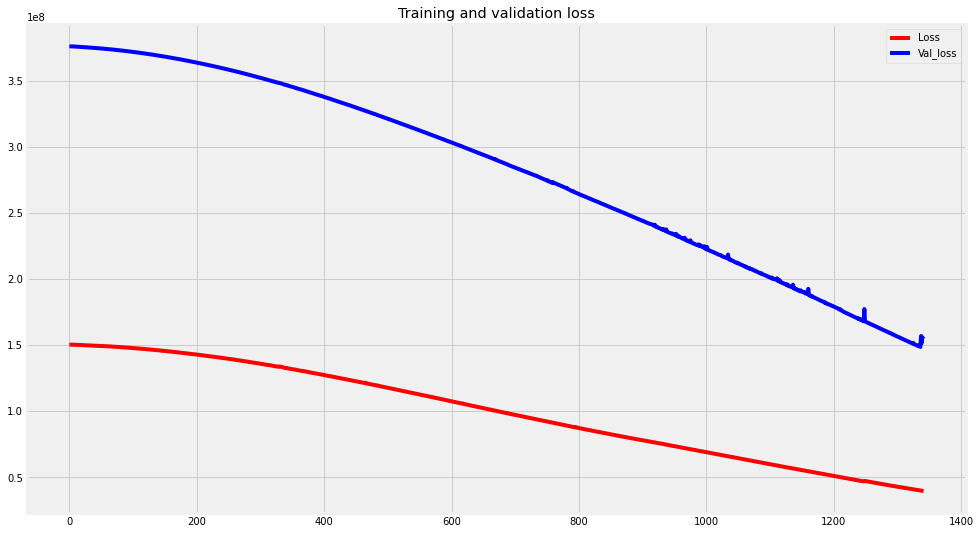

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize = (15,9))
plt.plot(epochs, loss, 'r', label='Loss')
plt.plot(epochs, val_loss, 'b', label = 'Val_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
prediction = model.predict(X_train_pad)

In [23]:
prediction

array([[  708.38885],
       [ 2544.8464 ],
       [ 7529.6367 ],
       [10320.784  ],
       [10319.918  ],
       [19131.64   ],
       [19131.762  ],
       [ 4144.221  ],
       [10295.489  ],
       [  446.9072 ],
       [  467.44278],
       [  442.68985],
       [  790.0833 ],
       [  506.97873],
       [15630.445  ],
       [  704.71924],
       [ 7220.716  ],
       [10289.494  ],
       [10285.832  ],
       [10281.115  ],
       [ 1898.1605 ],
       [ 6465.644  ],
       [  670.24243],
       [  524.80414],
       [  439.96127],
       [ 2811.2065 ],
       [  528.4241 ],
       [  974.25726],
       [  533.80164],
       [ 1722.5634 ],
       [ 6474.0396 ],
       [  634.6388 ],
       [10327.421  ],
       [ 4326.491  ],
       [ 2486.9272 ],
       [ 1080.3337 ],
       [19131.291  ],
       [ 2165.4336 ],
       [ 4087.6187 ],
       [ 4273.977  ],
       [ 6758.572  ],
       [  526.6254 ],
       [ 4725.1665 ],
       [10290.312  ],
       [  708.428  ],
       [ 6

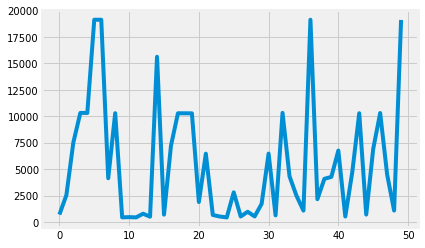

In [24]:
plt.plot(prediction)